In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


from task_4_core.hopfield import Hopfield 

2023-11-19 15:47:35.903944: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 15:47:35.956210: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 15:47:36.281806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 15:47:36.281858: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 15:47:36.284206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
def binarize(threshold, data):
    return np.where(data > threshold, 1, -1)

In [4]:
def get_input(threshold, class_count):
    train_index = np.where(train_labels < class_count)
    train_images_binarized = binarize(threshold, train_images).reshape(train_images.shape[0], train_images.shape[1] * train_images.shape[2])
    
    test_index = np.where(test_labels < class_count)
    test_images_binarized = binarize(threshold, test_images).reshape(test_images.shape[0], test_images.shape[1] * test_images.shape[2])

    return (train_images_binarized[train_index], train_labels[train_index]), (test_images_binarized[test_index], test_labels[test_index])

In [5]:
def hopfield_train_test(train_data_inp, test_data_inp, iterations, threshold=0, learning_rule='hebb', energy_function='classic', update_function='sync', async_iterations = 100):
    # pick first instances of each class as a reference
    train_data, labels = train_data_inp
    unique_labels = np.unique(labels)
    refs = list(map(lambda n: train_data[np.where(labels == n)[0][0]], unique_labels))

    # put them in network memory and train the network on them
    hopfield = Hopfield((28, 28))
    hopfield.train_weights(refs, learning_rule)

    test_data, labels_test = test_data_inp
    predictions = []

    # for each test:
    for test_iter in range(test_data.shape[0]):
        # example use the inference n times
        result = hopfield.predict([test_data[test_iter]], iterations, threshold, energy_function, update_function, async_iterations)[-1]
        
        # then pick the label of the reference that has the least different elements - this is the classification result
        refs_similarities = list(map(lambda ref: np.count_nonzero(ref==result), refs))
        label_predicted = refs_similarities.index(max(refs_similarities))
        predictions.append(label_predicted)

    # evaluate the metrics based on the results
    predictions = np.array(predictions)
    
    metrics = (
        accuracy_score(labels_test, predictions),
        f1_score(labels_test, predictions, average='macro'),
        recall_score(labels_test, predictions, average='macro'),
        precision_score(labels_test, predictions, average='macro', zero_division=0)
    )

    return hopfield, metrics

In [6]:
for class_count in range(2, 10):
    train, test = get_input(1, class_count)
    print(f"Classes: {class_count}")

    for iterations in range(1, 2, 1):
        model, (accuracy, f1, recall, precision) = hopfield_train_test(train, test, 10, 100, 'hebb', 'classic', 'sync')
        print(f"With {iterations} iterations: Accuracy: {accuracy}, F1: {f1}, Recall: {recall}, Precision: {precision}")

    print('\n\n\n')

    for iterations in range(1, 2, 1):
        model, (accuracy, f1, recall, precision) = hopfield_train_test(train, test, 10, 100, 'hebb', 'classic', 'async', async_iterations = 100)
        print(f"With {iterations} iterations: Accuracy: {accuracy}, F1: {f1}, Recall: {recall}, Precision: {precision}")

    print('\n\n\n')

Classes: 2
With 1 iterations: Accuracy: 0.9867612293144208, F1: 0.9866635558806467, Recall: 0.9857839611615571, Precision: 0.9878479840085808



With 1 iterations: Accuracy: 0.9872340425531915, F1: 0.9871409028727771, Recall: 0.9862941652431898, Precision: 0.9882695432388517



Classes: 3
With 1 iterations: Accuracy: 0.828725770575151, F1: 0.8287037920000827, Recall: 0.8244927578653631, Precision: 0.8444533764287708



With 1 iterations: Accuracy: 0.8350810295519543, F1: 0.8325461633582701, Recall: 0.8293947046427764, Precision: 0.848295371158879



Classes: 4


/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With 1 iterations: Accuracy: 0.35121481837863844, F1: 0.24651223223177426, Recall: 0.3433937779599085, Precision: 0.2859993364224955



With 1 iterations: Accuracy: 0.6560019244647582, F1: 0.6419762861233907, Recall: 0.6481951805955148, Precision: 0.7317737569691168



Classes: 5


/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With 1 iterations: Accuracy: 0.2303950184860868, F1: 0.12183759669617551, Recall: 0.2304209011209491, Precision: 0.20438443068687193
With 1 iterations: Accuracy: 0.5709281961471103, F1: 0.5144181456322509, Recall: 0.5585490248202949, Precision: 0.7083319838938962



Classes: 6


/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With 1 iterations: Accuracy: 0.1808986901011441, F1: 0.07075702075702077, Recall: 0.1785064189238307, Precision: 0.14041742860367987



With 1 iterations: Accuracy: 0.3765544685790085, F1: 0.3131321053836585, Recall: 0.3597597487945279, Precision: 0.6203526623500738



Classes: 7


/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With 1 iterations: Accuracy: 0.1752754328230076, F1: 0.08084438246162114, Recall: 0.16984030058134825, Precision: 0.12287843526342626



With 1 iterations: Accuracy: 0.3984833309486336, F1: 0.35049812408309483, Recall: 0.3828000265100571, Precision: 0.6138185583229595



Classes: 8


/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With 1 iterations: Accuracy: 0.16427591368342273, F1: 0.07784503649226462, Recall: 0.15863337985780956, Precision: 0.0947305962691539



With 1 iterations: Accuracy: 0.4796058375951104, F1: 0.43739277578568353, Recall: 0.4659079820153561, Precision: 0.5792210881349769



Classes: 9


/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With 1 iterations: Accuracy: 0.12212212212212212, F1: 0.041902985696836294, Recall: 0.12325012236906512, Precision: 0.06288170293676143



With 1 iterations: Accuracy: 0.25325325325325326, F1: 0.23488635720268825, Recall: 0.25128517795017424, Precision: 0.5336773756038277


In [7]:
def train_and_visualize(train, test, classes, hide_charts = False, test_len=20, learning_rule='hebb', energy_function='classic', update_function='sync'):
    
    references = list(map(lambda n: train[0][np.where(train[1] == n)[0]][0], classes))
    
    model = Hopfield((28, 28))
    model.train_weights(references, learning_rule)
    predictions = []
    
    for i in range(test_len):
        label = test[1][i]
        image = test[0][i]
        predicted = model.predict([image], 1, threshold=0, energy_function=energy_function, update_function=update_function)[0]
        
        reference_similarities = list(map(lambda ref: np.count_nonzero(ref == predicted), references))
        prediction = reference_similarities.index(max(reference_similarities))
        predictions.append(prediction)
        
        if not hide_charts:
            print(f'Predicted value = {prediction}, actual label = {label}')
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
            fig.tight_layout(pad=1.0)
            ax1.imshow(references[label].reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax1.set_title("Memory")
            ax2.imshow(image.reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax2.set_title("Input")
            ax3.imshow(predicted.reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax3.set_title("Output")
            ax4.imshow(references[prediction].reshape(28, 28), cmap='Greys',  interpolation='nearest')
            ax4.set_title("Closest memory")
            plt.show()
            
    test_metrics = test[1][:test_len]
    metrics = (
        accuracy_score(test_metrics, predictions),
        f1_score(test_metrics, predictions, average='macro'),
        recall_score(test_metrics, predictions, average='macro', zero_division=0),
        precision_score(test_metrics, predictions, average='macro', zero_division=0)
    )
    return metrics

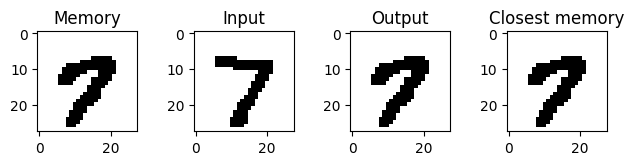

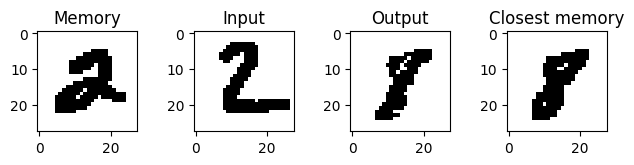

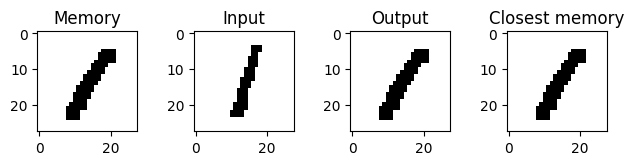

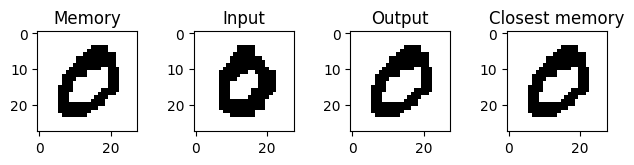

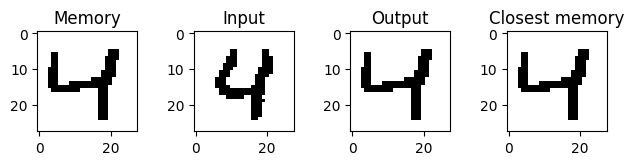

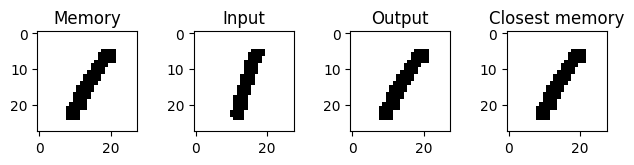

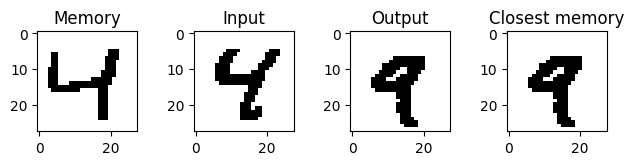

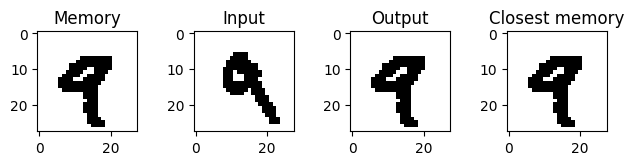

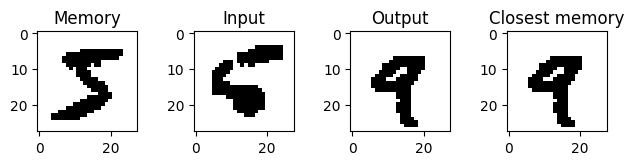

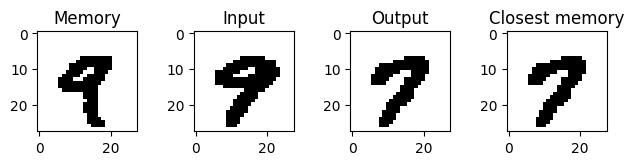

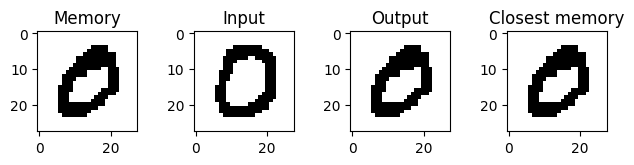

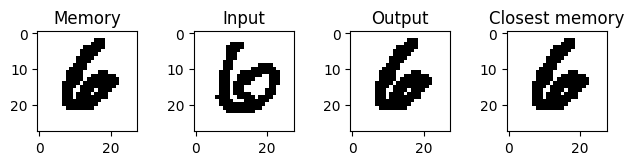

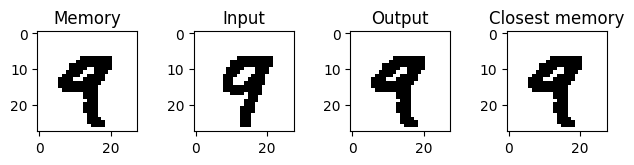

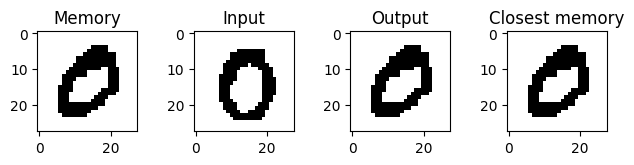

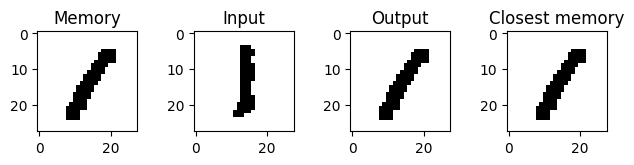

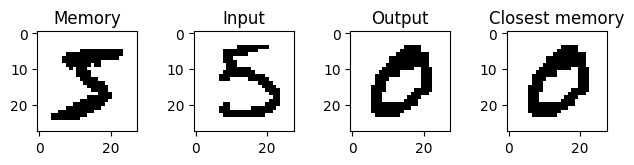

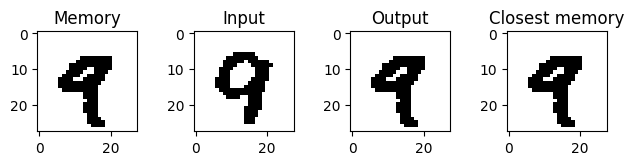

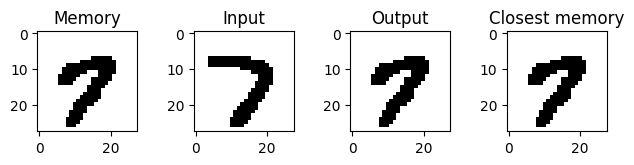

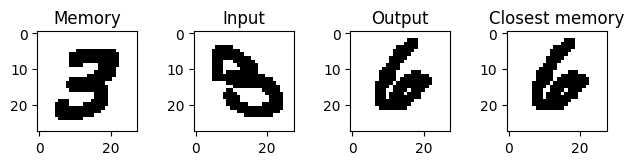

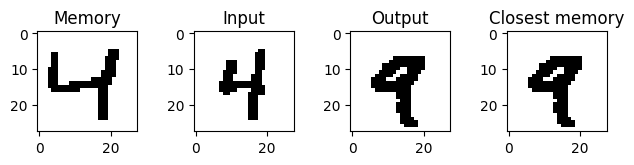

In [5]:
classes_count = 10
train, test = get_input(1, classes_count)
classes = list(np.unique(train[1]))
model = Hopfield((28,28))
references = list(map(lambda n: train[0][np.where(train[1] == n)[0]][0], classes))
model.train_weights(references, 'demircigil')
for i in range(20):
    label = test[1][i]
    image = test[0][i]
    predicted = model.predict([image], 1, threshold=0, energy_function='exp', update_function='demircigil')[0]

    reference_similarities = list(map(lambda ref: np.count_nonzero(ref == predicted), references))
    prediction = reference_similarities.index(max(reference_similarities))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
    fig.tight_layout(pad=1.0)
    ax1.imshow(references[label].reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax1.set_title("Memory")
    ax2.imshow(image.reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax2.set_title("Input")
    ax3.imshow(predicted.reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax3.set_title("Output")
    ax4.imshow(references[prediction].reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax4.set_title("Closest memory")
    plt.show()


### General parameters analysis

In [8]:
classes = [10]
threshold = range(0, 101, 10)
energy_funcs = ['exp', 'classic']
update_funcs = ['sync', 'async', 'demircigil']
learning_rules = ['hebb', 'storkey', 'demircigil']
full_cartesian = set(itertools.product(classes, energy_funcs, update_funcs, learning_rules))
broken_dem = set(itertools.product(classes, ['classic', 'exp'], ['sync', 'async'], ['demircigil']))
broken_dem = broken_dem.union(set(itertools.product(classes, ['classic'], ['demircigil'], ['demircigil'])))
print(broken_dem)
broken_combos = set(itertools.product(classes, ['classic', 'exp'], ['demircigil'], ['hebb', 'storkey'])).union(broken_dem)
result_product = full_cartesian.difference(broken_combos)
result = itertools.product(threshold, result_product)

energy_metrics = {func: {} for func in energy_funcs}
update_metrics = {func: {} for func in update_funcs}
rule_metrics =  {rule: {} for rule in learning_rules}

# SET HIDE_CHARTS TO FALSE TO ENABLE CHARTS ON LINE 19
for threshold, (classes_used, energy, update, rule) in result:
    train, test = get_input(threshold, classes_used)
    print(f'Using threshold - {threshold}')
    print(f'Using {classes_used} classes, {energy} energy func, {update} update method and {rule} learning rule')
    classes = list(np.unique(train[1]))
    metrics = train_and_visualize(train, test, classes, hide_charts=True, learning_rule=rule, energy_function=energy, update_function=update)
    energy_metrics[energy][threshold] = metrics
    update_metrics[update][threshold] = metrics
    rule_metrics[rule][threshold] = metrics
    print(f'Metrics:\nAccuracy - {metrics[0]},\nF1 - {metrics[1]},\nRecall - {metrics[2]},\nPrecision - {metrics[3]}')
    print('------------------------------------\n\n\n')

{(10, 'exp', 'sync', 'demircigil'), (10, 'classic', 'demircigil', 'demircigil'), (10, 'exp', 'async', 'demircigil'), (10, 'classic', 'async', 'demircigil'), (10, 'classic', 'sync', 'demircigil')}
Using threshold - 0
Using 10 classes, exp energy func, demircigil update method and demircigil learning rule
Metrics:
Accuracy - 0.65,
F1 - 0.4756613756613757,
Recall - 0.5648148148148149,
Precision - 0.4629629629629629
------------------------------------


Using threshold - 0
Using 10 classes, classic energy func, sync update method and storkey learning rule
Metrics:
Accuracy - 0.1,
F1 - 0.026143790849673203,
Recall - 0.07407407407407407,
Precision - 0.015873015873015872
------------------------------------


Using threshold - 0
Using 10 classes, classic energy func, async update method and storkey learning rule
Metrics:
Accuracy - 0.65,
F1 - 0.49523809523809526,
Recall - 0.537037037037037,
Precision - 0.5092592592592592
------------------------------------


Using threshold - 0
Using 10 cla

According to the results, we can see that the worst results are when using hebb learning rule with relatively small threshold.
The best accuracy result is 0.7. It's reached with :
    - hebb,storkey learning rules 
    - for threshold values <=20
    - exp and classic energy
    - async update

As we can see, predicted labels are coming directly from predicted images, which are produced by the Hopfield network by comparing to memory-cached training data. Overall accuracy is falling down when we increase train/test number of classes. This can be explained by the fact that wih higher number of train/test, there is more chances for "ugly" numbers to be either "cached" by the model, or tested. In this case, obviously, model is trying to find the closest similar picture, which often is not the right number, thus leading to decreased accuracy.

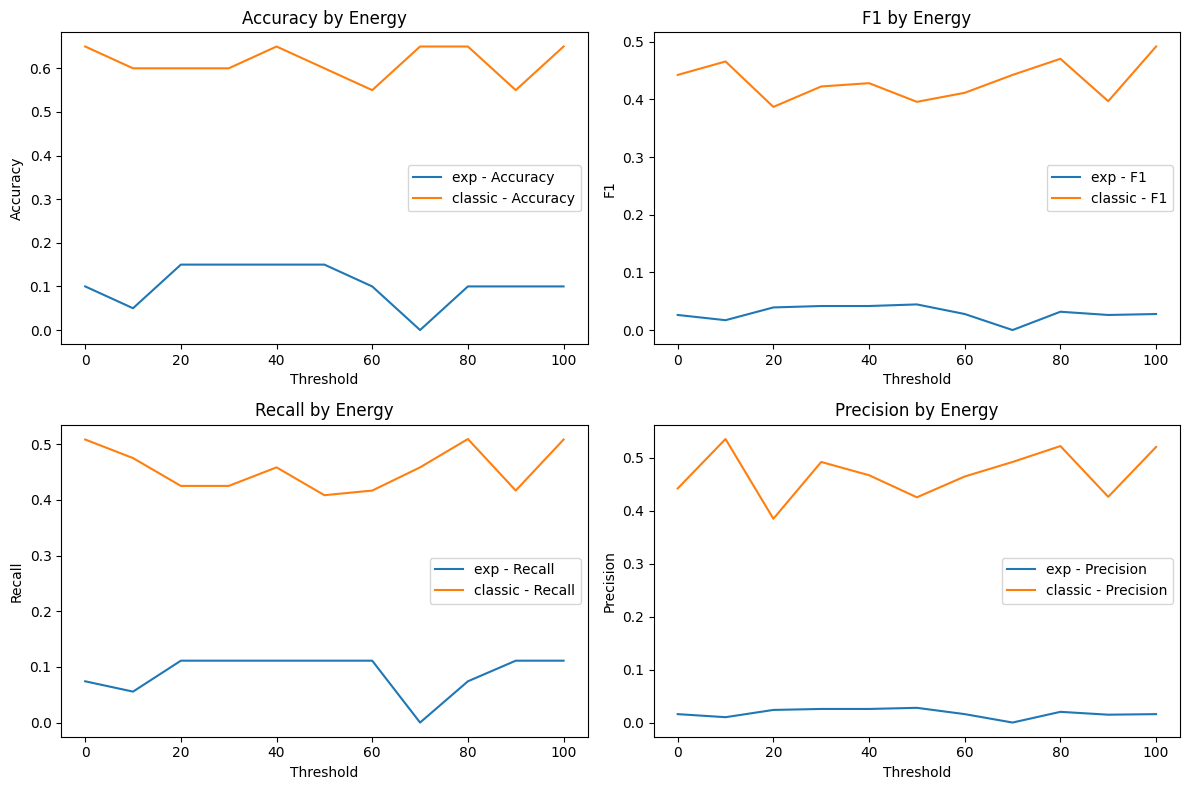

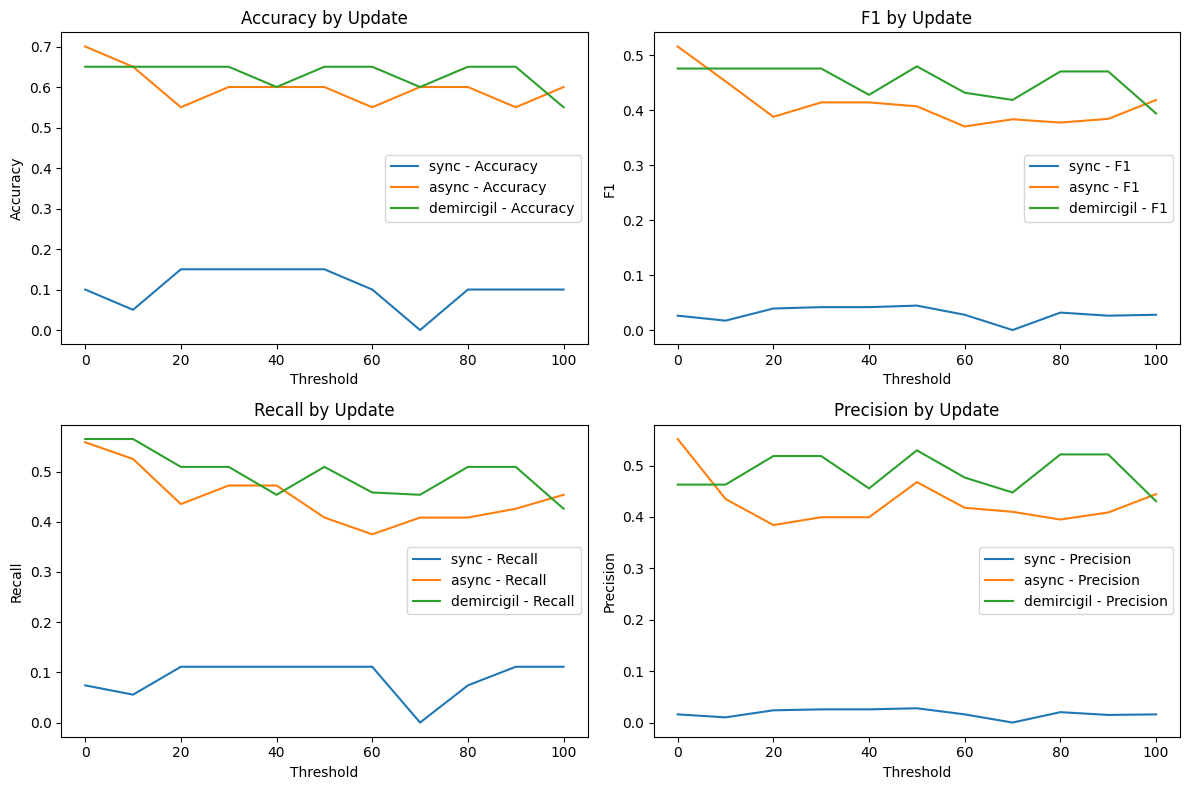

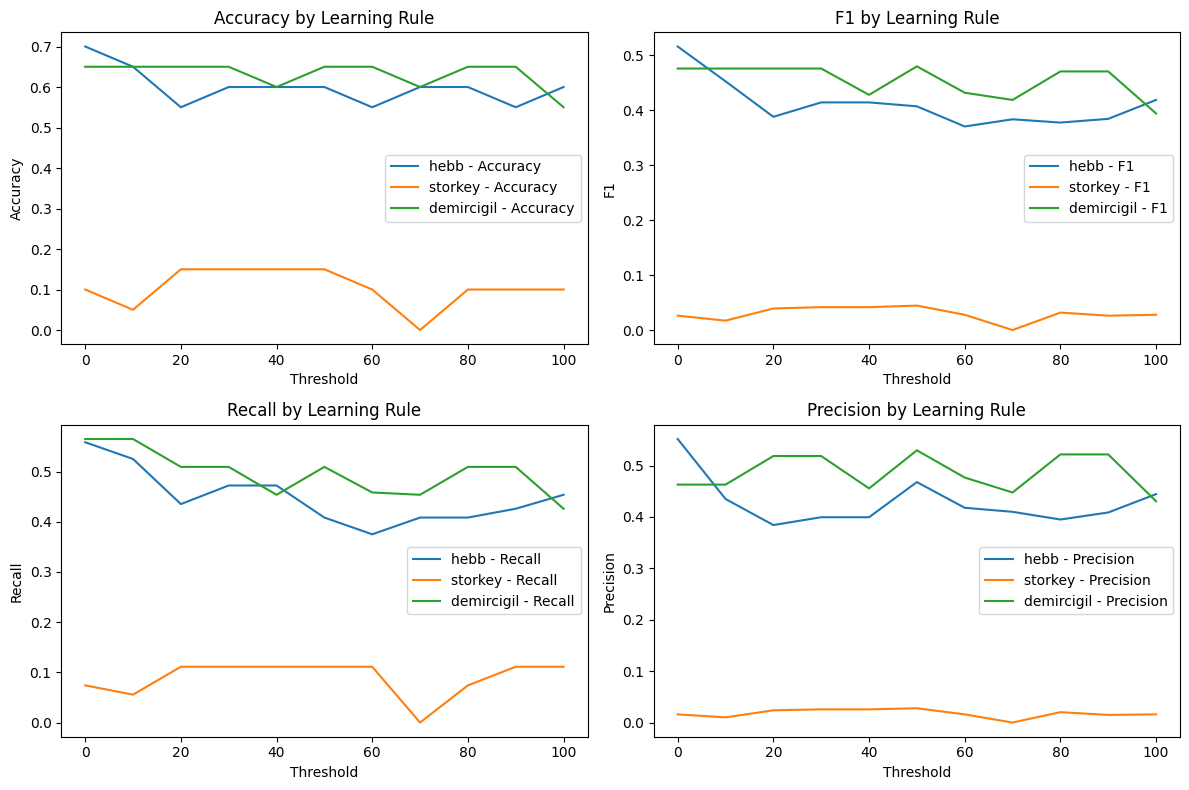

In [10]:
def visualize_dict_metrics(metrics_dict, metric_names, parameter_name):
    plt.figure(figsize=(12, 8))
    for func, metrics in metrics_dict.items():
        plt.subplot(2, 2, 1)
        plt.plot(metrics.keys(), [metric[0] for metric in metrics.values()], label=f'{func} - {metric_names[0]}')
        plt.title(f'{metric_names[0]} by {parameter_name}')
        plt.xlabel('Threshold')
        plt.ylabel(metric_names[0])
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(metrics.keys(), [metric[1] for metric in metrics.values()], label=f'{func} - {metric_names[1]}')
        plt.title(f'{metric_names[1]} by {parameter_name}')
        plt.xlabel('Threshold')
        plt.ylabel(metric_names[1])
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(metrics.keys(), [metric[2] for metric in metrics.values()], label=f'{func} - {metric_names[2]}')
        plt.title(f'{metric_names[2]} by {parameter_name}')
        plt.xlabel('Threshold')
        plt.ylabel(metric_names[2])
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(metrics.keys(), [metric[3] for metric in metrics.values()], label=f'{func} - {metric_names[3]}')
        plt.title(f'{metric_names[3]} by {parameter_name}')
        plt.xlabel('Threshold')
        plt.ylabel(metric_names[3])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Replace metric_names with the actual names of your metrics
metric_names = ['Accuracy', 'F1', 'Recall', 'Precision']

# Visualize energy_metrics
visualize_dict_metrics(energy_metrics, metric_names, 'Energy')

# Visualize update_metrics
visualize_dict_metrics(update_metrics, metric_names, 'Update')

# Visualize rule_metrics
visualize_dict_metrics(rule_metrics, metric_names, 'Learning Rule')

Based on visualizations, we can say that there is a great performance bug when threshold == 70.
For most parameters, the best performance is reached with threshold 0-20.